# CSE 252A Computer Vision I Fall 2019 - Homework 5

## Instructor: Ben Ochoa
### Assignment Published On: Thursday, November 21, 2019
### Due On: Saturday, December 7, 2019 11:59 pm

## Instructions
* Review the academic integrity and collaboration policies on the course website.
  * This assignment must be completed individually.
* All solutions must be written in this notebook.
  * Programming aspects of the assignment must be completed using Python in this notebook.
* If you want to modify the skeleton code, you may do so. It has only been provided as a framework for your solution.
* You may use Python packages (such as NumPy and SciPy) for basic linear algebra, but you may not use packages that directly solve the problem.
  * If you are unsure about using a specific package or function, then ask the instructor and/or teaching assistants for clarification.
* You must submit this notebook exported as a PDF. You must also submit this notebook as `.ipynb` file.
  * Submit both files (`.pdf` and `.ipynb`) on Gradescope.
  * **You must mark the PDF pages associated with each question in Gradescope. If you fail to do so, we may dock points.**
* It is highly recommended that you begin working on this assignment early.
* **Late policy: assignments submitted late will receive a 15% grade reduction for each 12 hours late (i.e., 30% per day). Assignments will not be accepted 72 hours after the due date. If you require an extension (for personal reasons only) to a due date, you must request one as far in advance as possible. Extensions requested close to or after the due date will only be granted for clear emergencies or clearly unforeseeable circumstances.**

## Problem 1: Optical Flow [14 pts]

In this problem, the multi-resolution Lucas-Kanade algorithm for estimating optical flow will be implemented, and the data needed for this problem can be found in the folder 'optical_flow_images'.

An example optical flow output is shown below - this is not a solution, just an example output.

![title](optical_flow_images/sample_optical_flow_output.png)

### Part 1: Multi-resolution Lucas-Kanade implementation [6 pts]

Implement the Lucas-Kanade method for estimating optical flow. The function 'LucasKanadeMultiScale' needs to be completed. You can implement 'upsample_flow' and 'OpticalFlowRefine' as 2 building blocks in order to complete this.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.ndimage.filters import gaussian_filter as gaussian
import scipy.misc as misc
import scipy
from tqdm import tqdm_notebook

def grayscale(img):
    '''
    Converts RGB image to Grayscale
    '''
    gray=np.zeros((img.shape[0],img.shape[1]))
    gray=img[:,:,0]*0.2989+img[:,:,1]*0.5870+img[:,:,2]*0.1140
    return gray

def plot_optical_flow(img,U,V,titleStr):
    '''
    Plots optical flow given U,V and one of the images
    '''
    
    # Change t if required, affects the number of arrows
    # t should be between 1 and min(U.shape[0],U.shape[1])
    t=10 
    
    # Subsample U and V to get visually pleasing output
    U1 = U[::t,::t]
    V1 = V[::t,::t]
    
    # Create meshgrid of subsampled coordinates
    r, c = img.shape[0],img.shape[1]
    cols,rows = np.meshgrid(np.linspace(0,c-1,c), np.linspace(0,r-1,r))
    cols = cols[::t,::t]
    rows = rows[::t,::t]
    
    # Plot optical flow
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.quiver(cols,rows,U1,V1)
    plt.title(titleStr)
    plt.show()
    

images=[]
for i in range(1,5):
    images.append(plt.imread('optical_flow_images/im'+str(i)+'.png')[:,:288,:])
# each image after converting to gray scale is of size -> 400x288

In [39]:
def downsample_image(im1,num_levels):
    
    # collect a list of all image sizes from smallest level to the original image
    
    small_images = [im1]
    for i in range(1,num_levels):
        half_size_image = scipy.ndimage.zoom(im1,.5)
        small_images.extend([half_size_image])
        im1 = half_size_image
        
    small_images = small_images[::-1] #flip the order so that we can start at the smallest level
    return small_images
    
def normalize(im1):
    minimum = np.min(im1)
    maximum = np.max(im1)
    norm_image = (im1-minimum)/(maximum-minimum)
    return norm_image

In [40]:
window = 13
im_shape = imgray.shape
im_shape

num_patches_y = im_shape[0]//window
remainder_y = im_shape[0]-num_patches_y*window
y_pad = remainder_y//2

num_patches_x = im_shape[1]//window
remainder_x = im_shape[1]-num_patches_x*window
x_pad = remainder_x//2


In [41]:
def calc_u_v(im1,im2,window):
    
    grad_x = np.array([[.5,0,-.5]])
    grad_y = np.array([[.5,0,-.5]]).T
    
    dx_im = convolve(im1,grad_x,mode = 'same')
    dy_im = convolve(im1,grad_y,mode = 'same')
    dt_im = im2-im1
    
    # break the image up into patches
    
    
    # shape of new image after kernel op with the window
    y_shape = len(list(range(window//2,im1.shape[0]-window//2)))
    x_shape = len(list(range(window//2,im1.shape[1]-window//2)))
    
    vector_shape = (y_shape,x_shape)
    u            = np.zeros(vector_shape)
    v            = np.zeros(vector_shape)
    
    row_index = 0
    col_index = 0
    
    for j in range(window//2,im1.shape[0]-window//2):
        
        for i in range(window//2,im1.shape[1]-window//2):  


            win_j_min = j-window//2
            win_j_max = j+window//2+1
            win_i_min = i-window//2
            win_i_max = i+window//2+1
            
           
            #        [4+13-13//2,4+13+6 (+1)] = [11,23]
            window_x = dx_im[win_j_min:win_j_max,\
                             win_i_min:win_i_max]
#             if i == window//2 and j == window//2:
#                 print(window_x.shape)
                
            window_y = dy_im[win_j_min:win_j_max,\
                             win_i_min:win_i_max]
            
            window_t = dt_im[win_j_min:win_j_max,\
                             win_i_min:win_i_max]
            
            Ixx = np.sum(window_x*window_x)
            Iyy = np.sum(window_y*window_y)
            Ixy = np.sum(window_x*window_y)
            Ixt = np.sum(window_x*window_t)
            Iyt = np.sum(window_y*window_t)
            
            A = np.array([[Ixx,Ixy],[Ixy,Iyy]])
            A_inv = np.linalg.pinv(A)
            b = -np.array([[Ixt],[Iyt]])
            
            sol = A_inv@b
            
            u[col_index,row_index] = sol[0]
            v[col_index,row_index] = sol[1]
            
            row_index +=1
            if row_index == x_shape:
                row_index = 0
                col_index +=1
    
    # pad the outside of these
    #print(u.shape)
    pad_w = int((window//2))
    u = np.pad(u,(pad_w,pad_w),mode = 'edge')
    v = np.pad(v,(pad_w,pad_w),mode = 'edge')
    #print(u.shape)
    return u,v
    
    

In [42]:
def warp_image(im1,u,v):
    
    im1_copy = im1.copy()
    y_shape = len(list(range(window//2,im1.shape[0]-window//2)))
    x_shape = len(list(range(window//2,im1.shape[1]-window//2)))
    
    
    for j in range(window//2,im1.shape[0]-window//2,window):
        
        for i in range(window//2,im1.shape[1]-window//2,window):  

            win_j_min = j-window//2
            win_j_max = j+window//2+1
            win_i_min = i-window//2
            win_i_max = i+window//2+1
            
            # take the center velocity values of each patch
            patch_u = np.round(u[j,i],0).astype(int)
            patch_v = np.round(v[j,i],0).astype(int)
            
            new_coordsj_min = patch_v+j-window//2
            new_coordsj_max = patch_v+j+window//2+1
            new_coordsi_min = patch_u+i-window//2
            new_coordsi_max = patch_u+i+window//2+1
            
            try: # make sure we are moving within the image space
                im1_copy[new_coordsj_min:new_coordsj_max,new_coordsi_min:new_coordsi_max]\
                        = im1[win_j_min:win_j_max,win_i_min:win_i_max]
            except:
                pass
            
            
#     for j in range(u.shape[0]):
#         for i in range(u.shape[1]):
#             try:
#                 im_1_warp_coords = [j+int(v[j,i]),i+int(u[j,i])]
#                 im1_copy[im_1_warp_coords] = im1[j,i]
#             except:
#                 pass
            
    return(im1_copy)
    

In [101]:
yu,yv = calc_u_v(imgray,imgray1,13)


In [102]:
y_shape = len(list(range(window//2,imgray.shape[0]-window//2,window)))
y_shape

30

In [43]:
# you can use interpolate from scipy
# You can implement 'upsample_flow' and 'OpticalFlowRefine' 
# as 2 building blocks in order to complete this.
from scipy.interpolate import interp2d as interpolate

def upsample_flow(u_prev, v_prev):
    ''' You may implement this method to upsample optical flow from
    previous level
    u_prev, v_prev -> optical flow from prev level
    u, v -> upsampled optical flow to the current level
    '''
    """ ==========
    YOUR CODE HERE
    
    https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.interp2d.html
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.html
    ========== """
    
    y = list(range(u_prev.shape[0])) #create u,v indexes
    x = list(range(u_prev.shape[1])) 
    
    y2 = [2*i for i in y] # scale all the index values by 2
    x2 = [2*i for i in x]
    
    u_prev_scaled = u_prev*2 # scale the magnitudes by 2
    v_prev_scaled = v_prev*2
    
    f_u = interpolate(x2,y2,u_prev_scaled,kind = 'linear') # create the interpolation function
    f_v = interpolate(x2,y2,v_prev_scaled,kind = 'linear')
    
    x_new_coords = list(range(len(x2)*2)) #create the new coordinates for the larger image
    y_new_coords = list(range(len(y2)*2))
    
    u = f_u(x_new_coords,y_new_coords) #create the new set of 
    v = f_v(x_new_coords,y_new_coords)

    return u, v

def OpticalFlowRefine(im1,im2,window, u_prev=None, v_prev=None):
    '''
    Inputs: the two images at current level and window size
    u_prev, v_prev - previous levels optical flow
    Return u,v - optical flow at current level
    '''
    # if we are on the first level, initialize the values to zero
    if u_prev is None:
        u_scaled = np.zeros(im1.shape)
        v_scaled = np.zeros(im2.shape)
        
        # otherwise upsample flow from previous level
    else:
        u_scaled, v_scaled = upsample_flow(u_prev, v_prev)
    
    # create variables to store total velocity vectors
    total_u = u_scaled
    total_v = v_scaled
    #print('total u',total_u.shape)
        
    im1 = warp_image(im1,u_scaled,v_scaled) # pre warp image with previous velo vectors
    #print(im1.shape,im2.shape)
    res_u,res_v = calc_u_v(im1,im2,window)
    #print('resu',res_u.shape)
    total_u += res_u
    total_v += res_v
    
    return total_u, total_v

In [44]:
def LucasKanadeMultiScale(im1,im2,window, numLevels=2):
    '''
    Implement the multi-resolution Lucas kanade algorithm
    Inputs: the two images, window size and number of levels
    if numLevels = 1, then compute optical flow at only the given image level.
    Returns: u, v - the optical flow
    '''
    
    """ ==========
    YOUR CODE HERE
    ========== """
    
    # You can call OpticalFlowRefine iteratively
    imgray1 = grayscale(im1)
    imgray2 = grayscale(im2)
    
    #normalize the images
    imgray1n = normalize(imgray1)
    imgray2n = normalize(imgray2)
    #print(imgray1n.shape)
    # create our list of downsampled images
    imgray1_list = downsample_image(imgray1n,numLevels)
    imgray2_list = downsample_image(imgray2n,numLevels)
    #print(len(imgray1_list))
    #print(imgray1_list[0].shape)
    # initialize the u and v values
    u = None
    v = None
    
    # iterate through our levels
    for i in range(len(imgray1_list)):
        im_1 = imgray1_list[i]
        im_2 = imgray2_list[i]
        #print(im_1)
        u,v = OpticalFlowRefine(im_1,im_2,window,u,v)
         
    return u, v

### Part 2: Number of levels [2 pts]

Plot optical flow for the pair of images im1 and im2 for different number of levels mentioned below. Comment on the results and justify.<br>
(i) window size = 13, numLevels = 1<br>
(ii) window size = 13, numLevels = 3<br>
(iii) window size = 13, numLevels = 5<br>
So, you are expected to provide 3 outputs here<br>

Note: if numLevels = 1, then it means the optical flow is only computed at the image resolution i.e. no downsampling

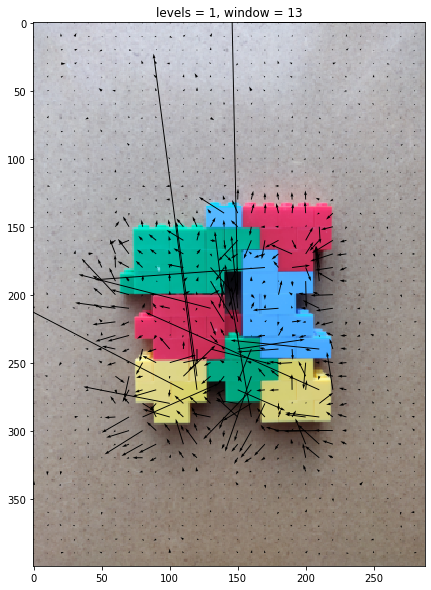

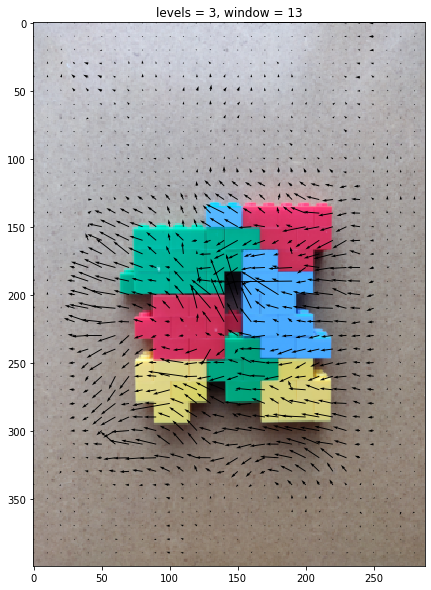

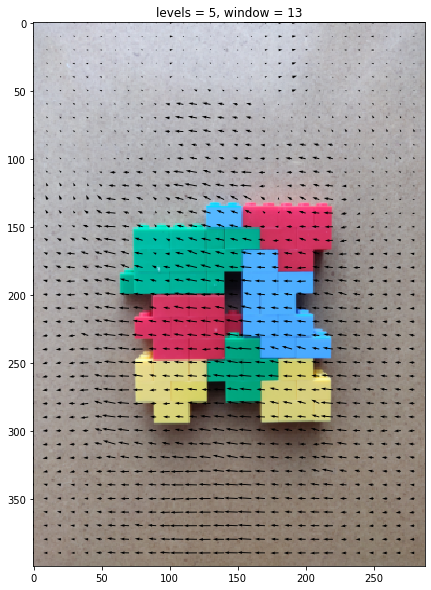

In [45]:
# Example code to generate output
window=13
numLevels=1
U,V=LucasKanadeMultiScale(images[0],images[1],\
                          window,numLevels)
plot_optical_flow(images[0],U,-V, \
                  'levels = ' + str(numLevels) + ', window = '+str(window))

numLevels=3
U,V=LucasKanadeMultiScale(images[0],images[1],\
                          window,numLevels)
plot_optical_flow(images[0],U,-V, \
                  'levels = ' + str(numLevels) + ', window = '+str(window))
numLevels=5
U,V=LucasKanadeMultiScale(images[0],images[1],\
                          window,numLevels)
plot_optical_flow(images[0],U,-V, \
                  'levels = ' + str(numLevels) + ', window = '+str(window))

#### Your Comments on the results of Part 2:

1: with just one level we see that the flow calculations are widely off, and that is because we have violated the small motion motion assumption. The movement of the object in the image is much greater than one pixel and so the conditions for our taylor series approximation is violated.

2: We see an improvement above the single level. Nearby pixels are beginning to move together, but there are still eddy's within the flow that are not aligned with the motion and would warp the object that is in motion if it was true. 

3: With 5 levels we see that optical flow predictions aligning with the motion of the object  (to the left and slightly up) and any changes between subequent flow predictions are more gradual. Additionally, at this level it is able to begin to make out the flow of the background and the background motion coincides with the motion of the object. Because the background is so close we don't have any parallax effect. 

### Part 3: Window size [3 pts]

Plot optical flow for the pair of images im1 and im2 for at least 3 different window sizes which leads to observable difference in the results. Comment on the effect of window size on results and justify. For this part fix the number of levels to be 3.

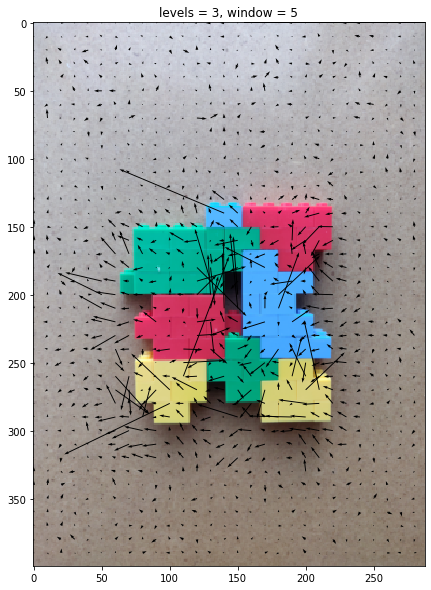

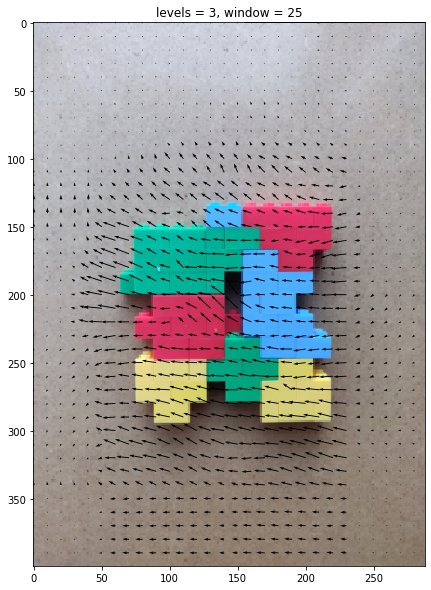

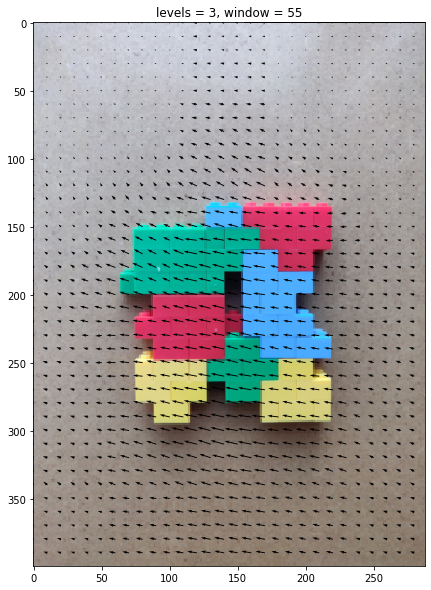

In [114]:
# Example code, change as required
numLevels=3

w1, w2, w3 = 5, 25, 55
for window in [w1, w2, w3]:
    U,V=LucasKanadeMultiScale(images[0],images[1],\
                              window,numLevels)
    plot_optical_flow(images[0],U,-V, \
                      'levels = ' + str(numLevels) + ', window = '+str(window))

#### Your Comments on the results of Part 3:

With small windows we are unable to effectively identify corner features or high texture regions because we don't have enough space to capture those regions. Additionally, the motion of the object could be greater than the window size, completely violating the assumptions used to calculate the motion. 

As we increase window size we are able to accurately capture more of the high texture features, and therefore more accurately predict the motion, Additionally, the motion of the object is larger contained within the window, as only a portion of the pixels move out of the window in the second frame. 

As we continue to go larger, the windows begin to eclipse multiple features, and therefore we are grouping sections that shouldn't necessarily be grouped together and we see large patches of flow vectors moving together across regions or features. Therefore if we have multiple objects we are tracking that are close in proximity we should make sure our window is of adequate size to capture object features but not so large that we are blending movements of multiple objects together. 

### Part 4: All pairs [3 pts]

Find optical flow for the pairs (im1,im2), (im1,im3), (im1,im4) using one good window size and number of levels. Does the optical flow result seem consistent with visual inspection? Comment on the type of motion indicated by results and visual inspection and explain why they might be consistent or inconsistent.

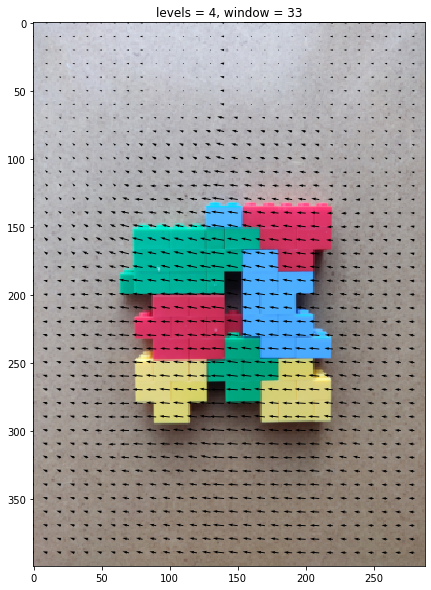

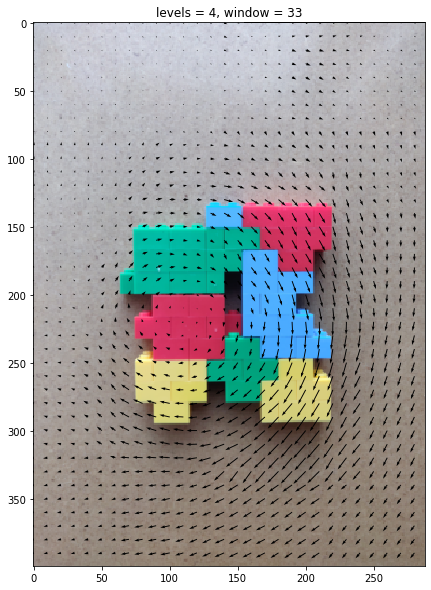

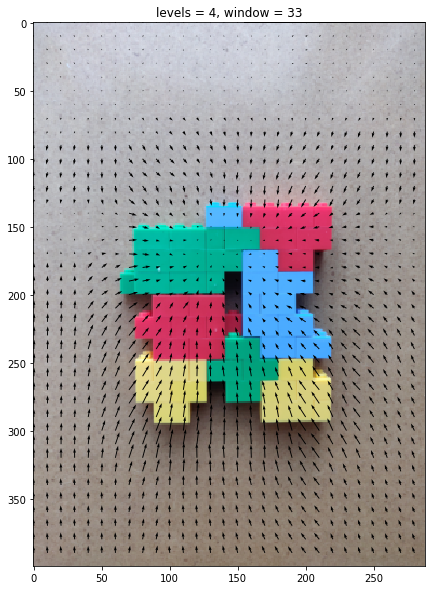

In [48]:
# Your code here
# use one fixed window and numLevels for all pairs
numLevels = 4
window = 33
for i in range(3):
    U,V=LucasKanadeMultiScale(images[0],images[i+1],\
                              window,numLevels)
    plot_optical_flow(images[0],U,-V, \
                      'levels = ' + str(numLevels) + ', window = '+str(window))

#### Your Comments on the results of Part 4:

For the most part the results seem consistent with what would be expected. Image three is a rotation, and image 4 appears to be zooming out and possibly a change in focal length. 

In image 3 the flow vectors get longer wth the distance away from the center of the rotation which is logical. For both image 3 and 4 as we get into the low texture areas in the background, and especially at the top of the image, we see lose the ability to calculate the movement due to the similarity of pixels and that yields little to no motion calculation.


## Problem 2: Machine Learning [12 pts]

In this problem, you will implement several machine learning solutions for computer vision problems.

### Part 1: Initial setup [1 pts]

Follow the directions on https://pytorch.org/get-started/locally/ to install Pytorch on your computer. 

Note: You will not need GPU support for this assignment so don't worry if you don't have one. Furthermore, installing with GPU support is often more difficult to configure so it is suggested that you install the CPU only version. TA's will not provide any support related to GPU or CUDA.

Run the torch import statements below to verify your instalation.

Download the MNIST data from http://yann.lecun.com/exdb/mnist/.

Download the 4 zipped files, extract them into one folder, and change the variable 'path' in the code below. (Code taken from https://gist.github.com/akesling/5358964 )

Plot one random example image corresponding to each label from training data.

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
from torchvision.datasets import MNIST
# mnist = MNIST('.', download=True)
import numpy as np
import matplotlib.pyplot as plt
import time



In [4]:
import os
import struct

# Change path as required
path = '.\MNIST'

def read(dataset = "training", datatype='images'):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)
    
    if(datatype=='images'):
        get_data = lambda idx: img[idx]
    elif(datatype=='labels'):
        get_data = lambda idx: lbl[idx]

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_data(i)
        
trainData=np.array(list(read('training','images')))
trainLabels=np.array(list(read('training','labels')))
testData=np.array(list(read('testing','images')))
testLabels=np.array(list(read('testing','labels')))

In [5]:
# Understand the shapes of the each variable carying data
print(trainData.shape, trainLabels.shape)
print(testData.shape, testLabels.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


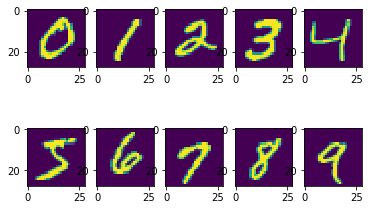

In [6]:
# display one image from each label
for i in range(10):
    plt.subplot(2,5,i+1)
    i_loc = np.where(trainLabels==i)[0][0]
    plt.imshow(trainData[i_loc,:,:])

Some helper functions are given below.

In [13]:
# a generator for batches of data
# yields data (batchsize, 28, 28) and labels (batchsize)
# if shuffle, it will load batches in a random order
def DataBatch(data, label, batchsize, shuffle=True):
    n = data.shape[0]
    if shuffle:
        index = np.random.permutation(n)
    else:
        index = np.arange(n)
    for i in range(int(np.ceil(n/batchsize))):
        inds = index[i*batchsize : min(n,(i+1)*batchsize)]
        yield data[inds], label[inds]

# tests the accuracy of a classifier
def test(testData, testLabels, classifier):
    start_time = time.time()
    batchsize=50
    correct=0.
    for data,label in DataBatch(testData,testLabels,batchsize,shuffle=False):
        prediction = classifier(data)
        correct += np.sum(prediction==label)
    #print(len(prediction))
    end_time = time.time()
    #print('time:',end_time - start_time)
    return correct/testData.shape[0]*100

# a sample classifier
# given an input it outputs a random class
class RandomClassifier():
    def __init__(self, classes=10):
        self.classes=classes
    def __call__(self, x):
        return np.random.randint(self.classes, size=x.shape[0]) # updated this to be equal to 1

randomClassifier = RandomClassifier()
print('Random classifier accuracy: %f' % 
      test(testData, testLabels, randomClassifier))

Random classifier accuracy: 10.310000


### Part 2: Confusion Matrix [2 pts]
Here you will implement a function that computes the confusion matrix for a classifier.
The matrix (M) should be nxn where n is the number of classes.
Entry M[i,j] should contain the fraction of images of class i that was classified as class j.
Can you justify the accuracy given by the random classifier?

In [1]:
#Using the tqdm module to visualize run time is suggested
from tqdm import tqdm

# It would be a good idea to return the accuracy, along with the confusion 
# matrix, since both can be calculated in one iteration over test data, to 
# save time
def Confusion(testData, testLabels, classifier):
    M=np.zeros((10,10))
    acc=0.0
    
    
    pred_label = classifier(testData)
    
    for i in tqdm(range(len(testData))):
        M[testLabels[i],pred_label[i]] += 1 
    
    raw_M = M #for specificity later
    for i in tqdm(range(M.shape[0])):
        M[i,:] = M[i,:]/np.sum(M[i,:])
    
    acc = np.sum(np.diagonal(M))/np.sum(M)
    
    return M,raw_M, acc
    

def VisualizeConfusion(M):
    plt.figure(figsize=(14, 6))
    plt.imshow(M)
    plt.show()
    print(np.round(M,3))

M,acc = Confusion(testData, testLabels, randomClassifier)
VisualizeConfusion(M)
print('accuracy:',acc)

ModuleNotFoundError: No module named 'tqdm'

#### Your Comments on the accuracy & confusion matrix of random classifier:

The accuracy is what you would expect for a random classifier with 10 classes, it gets the class right about 10% of the time and the false positives are split evenly among all of the other classes

### Part 3: K-Nearest Neighbors (KNN) [4 pts]

* Here you will implement a simple knn classifier. The distance metric is Euclidean in pixel space. k refers to the number of neighbors involved in voting on the class, and should be 3. You are allowed to use sklearn.neighbors.KNeighborsClassifier.
* Display confusion matrix and accuracy for your KNN classifier trained on the entire train set. (should be ~97 %)
* After evaluating the classifier on the testset, based on the confusion matrix, mention the number that the number '7' is most often predicted to be, other than '7'.

In [86]:
trainData.shape

(60000, 28, 28)

In [8]:
trainData[:100].reshape((-1,trainData.shape[1]*trainData.shape[2])).shape

(100, 784)

In [9]:
from sklearn.neighbors import KNeighborsClassifier as KNN
class KNNClassifier():
    def __init__(self, k=3):
        # k is the number of neighbors involved in voting
        self.k = k
        self.KNNModel = KNN(n_neighbors = self.k) # initialize the model
        
    def train(self, trainData, trainLabels):
        
        trainData = trainData.reshape((-1,trainData.shape[1]*trainData.shape[2]))
        #print(trainData.shape,trainLabels.shape)
        self.KNNModel.fit(trainData,trainLabels)
        
    def __call__(self, x):
        
        x = x.reshape((-1,x.shape[1]*x.shape[2]))
        y_pred = self.KNNModel.predict(x)
        return y_pred
        
        """ ==========
        YOUR CODE HERE
        ========== """


# test your classifier with only the first 100 training examples (use this
# while debugging)
# note you should get ~ 65 % accuracy
knnClassifierX = KNNClassifier()
knnClassifierX.train(trainData[:100], trainLabels[:100])
print ('KNN classifier accuracy: %f'%test(testData, testLabels, knnClassifierX))

time: 2.1421468257904053
KNN classifier accuracy: 64.760000


In [22]:
# test your classifier with all the training examples (This may take a while)
knnClassifier = KNNClassifier()
knnClassifier.train(trainData, trainLabels)

In [11]:
trainData[0].shape

(28, 28)

(10000, 28, 28)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]


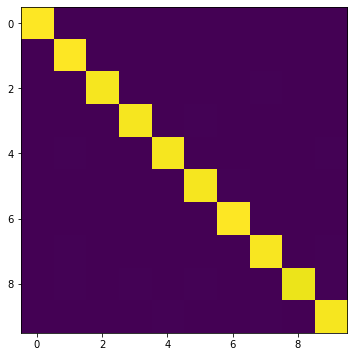

[[0.997 0.001 0.    0.    0.    0.001 0.001 0.    0.    0.   ]
 [0.    0.998 0.001 0.    0.    0.    0.    0.001 0.    0.   ]
 [0.004 0.004 0.985 0.001 0.    0.    0.001 0.006 0.001 0.   ]
 [0.001 0.001 0.003 0.984 0.    0.004 0.    0.003 0.002 0.002]
 [0.001 0.005 0.    0.    0.984 0.    0.001 0.001 0.    0.007]
 [0.002 0.    0.001 0.004 0.001 0.985 0.006 0.    0.    0.001]
 [0.002 0.001 0.    0.    0.001 0.    0.996 0.    0.    0.   ]
 [0.    0.005 0.001 0.    0.001 0.    0.    0.987 0.    0.004]
 [0.002 0.007 0.002 0.006 0.003 0.005 0.002 0.002 0.967 0.005]
 [0.002 0.001 0.    0.003 0.004 0.001 0.    0.005 0.001 0.983]]
accuracy: 0.9865277692207901


In [89]:
M,acc = Confusion(trainData, trainLabels, knnClassifier)
VisualizeConfusion(M)
print('accuracy:',acc)

#### Answer

The next highest prediction was 2: .005

### Part 4: Principal Component Analysis (PCA) K-Nearest Neighbors (KNN) [5 pts]
Here you will implement a simple KNN classifer in PCA space (for k=3 and 25 principal components).
You should implement PCA yourself using svd (you may not use sklearn.decomposition.PCA
or any other package that directly implements PCA transformations

Is the testing time for PCA KNN classifier more or less than that for KNN classifier? Comment on why it differs if it does.

In [16]:
class PCAKNNClassifier():
    def __init__(self, components=25, k=3):
        # components = number of principal components
        # k is the number of neighbors involved in voting
        self.components = components
        self.k = k
        
    def train(self, trainData, trainLabels):
        
        #flatten the training data
        trainData = np.reshape(trainData,(-1,trainData.shape[1]*trainData.shape[2]))
        self.td = trainData
        self.tl  = trainLabels
        
        # center the training_data
        self.td_mean = np.mean(self.td,axis = 0)
        self.centered_td = self.td - self.td_mean
        
        # get the top 25 eigenvectors
        _,_,vt = np.linalg.svd(self.centered_td,full_matrices = False)
        v = vt.T
        self.top_25 = v[:,:25]
        self.train_25 = self.centered_td@self.top_25@self.top_25.T + self.td_mean
        self.KNNModel = KNN(n_neighbors = self.k)
        self.KNNModel.fit(self.train_25,trainLabels)
        
        
    def __call__(self, x):
        # this method should take a batch of images
        # and return a batch of predictions
        
        # reshape x
        x = np.reshape(x,(-1,x.shape[1]*x.shape[2]))
        x_centered = x - self.td_mean
        
        #project x and reconstruct x in eigenspace
        test_25 = x_centered@self.top_25@self.top_25.T + self.td_mean
        
        #predict the output classes
        y_pred = self.KNNModel.predict(test_25)
        
        return y_pred


# test your classifier with only the first 100 training examples (use this
# while debugging)
pcaknnClassifierX = PCAKNNClassifier()
pcaknnClassifierX.train(trainData[:100], trainLabels[:100])
print ('KNN classifier accuracy: %f'%test(testData, testLabels, pcaknnClassifierX))

time: 3.133495330810547
KNN classifier accuracy: 66.160000


In [92]:
# test your classifier with all the training examples
pcaknnClassifier = PCAKNNClassifier()
pcaknnClassifier.train(trainData, trainLabels)

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10017.44it/s]


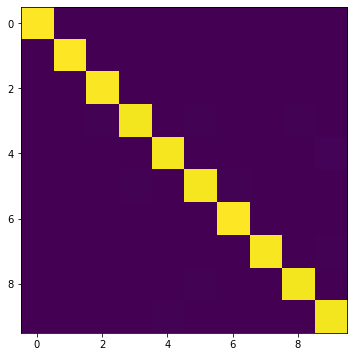

[[0.996 0.    0.001 0.    0.    0.001 0.001 0.    0.    0.   ]
 [0.    0.996 0.001 0.    0.    0.    0.    0.001 0.    0.   ]
 [0.002 0.002 0.991 0.001 0.    0.    0.    0.003 0.001 0.001]
 [0.001 0.001 0.005 0.978 0.    0.005 0.    0.002 0.005 0.002]
 [0.001 0.002 0.    0.    0.984 0.    0.002 0.001 0.    0.009]
 [0.001 0.001 0.001 0.004 0.001 0.984 0.005 0.    0.001 0.001]
 [0.001 0.001 0.    0.    0.001 0.002 0.995 0.    0.    0.   ]
 [0.    0.003 0.002 0.    0.002 0.    0.    0.988 0.    0.005]
 [0.001 0.003 0.002 0.003 0.002 0.004 0.001 0.001 0.98  0.002]
 [0.001 0.002 0.001 0.003 0.005 0.001 0.    0.004 0.002 0.981]]
accuracy: 0.9873427386080209


In [93]:
# display confusion matrix for your PCA KNN classifier with all the training examples
M,acc = Confusion(trainData, trainLabels, pcaknnClassifier)
VisualizeConfusion(M)
print('accuracy:',acc)

#### Comments:
In my case the PCA KNN classifier runs slower, but that is due to the fact that the test set is relatively small ~ 10K samples and I have to do some preliminary operations to transform the data into the lower dimensional space but if the data set grows in size the PCA classifier should move faster over a larger dataset since it only has to compare distances across 25 dimensions instead of 784

## Problem 3: Deep learning [14 pts]
Below is some helper code to train your deep networks.

### Part 1:  Training with PyTorch [2 pts]
Below is some helper code to train your deep networks. 
Complete the train function for DNN below. You should write down the training operations in this function. That means, for a batch of data you have to initialize the gradients, forward propagate the data, compute error, do back propagation and finally update the parameters. This function will be used in the following questions with different networks.
You can look at https://pytorch.org/tutorials/beginner/pytorch_with_examples.html for reference.

In [10]:
# base class for your deep neural networks. It implements the training loop (train_net).
# You will need to implement the "__init__()" function to define the networks
# structures and "forward()", to propagate your data, in the following problems.

import torch.nn.init
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from tqdm import tqdm
from scipy.stats import truncnorm

class DNN(nn.Module):
    def __init__(self,td):
        '''
        d_in = input dimension
        d_out = output dimension
        num_hidden = number of hidden layers
        w1 = hidden layer weights
        w2 = hidden layer biases
        
        '''
        super().__init__()
        self.d_in  = td.shape[1]*td.shape[2]
        self.d_out = len(np.unique(trainLabels))
        self.num_hidden = 50
        self.dtype = torch.float
        self.device = torch.device("cpu")
        
        # define the network structure
        model = torch.nn.Sequential(\
                torch.nn.Linear(self.d_in,self.num_hidden),\
                torch.nn.ReLU(),\
                torch.nn.Linear(self.num_hidden,self.d_out))
        
        #need to initialize the weights
        
        
#         self.w1 = torch.randn(self.d_in,self.num_hidden,\
#                               device=self.device,dtype=self.dtype,requires_grad = True)
#         self.w2 = torch.randn(self.num_hidden,self.d_out,\
#                               device=self.device,dtype=self.dtype,requires_grad = True)
        self.model = model
        pass
    
    def forward(self, x):
#         raise NotImplementedError
#         h = x.mm(self.w1)
#         h_relu = h.clamp(min=0)
#         yp = h_relu.mm(w2)
                                    
        yp = self.model(x)
        return yp
    
    def train_net(self, trainData, trainLabels, epochs=1, batchSize=50):
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr = 3e-4)
        
        for epoch in range(epochs):
            self.train()  # set netowrk in training mode
            for i, (data,labels) in enumerate(DataBatch(trainData, trainLabels, batchSize, shuffle=True)):
                data = Variable(torch.FloatTensor(data))
                #print(data.shape)
                labels = Variable(torch.LongTensor(labels))
                
                # YOUR CODE HERE------------------------------------------------
                # Train the model using the optimizer and the batch data
                
                y_pred = self.forward(data)
                loss = criterion(y_pred,labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

#                 # update weights
                
#                 with torch.no_grad():
                    
#                     w1 -= learning_rate*w1.grad
#                     w2 -= learning_rate*w2.grad 
                                    
#                     w1.grad.zero_()
#                     w2.grad.zero_()
                
            
                    
                #------------------------------------------------------------------
                #-----End of your code, don't change anything else here------------
                
            self.eval()  # set network in evaluation mode
            print ('Epoch:%d Accuracy: %f'%(epoch+1, test(testData, testLabels, self))) 
    
    def __call__(self, x):
        inputs = Variable(torch.FloatTensor(x))
        prediction = self.forward(inputs)
        return np.argmax(prediction.data.cpu().numpy(), 1)

# helper function to get weight variable
def weight_variable(shape):
    initial = torch.Tensor(truncnorm.rvs(-1/0.01, 1/0.01, scale=0.01, size=shape))
    return Parameter(initial, requires_grad=True)

# helper function to get bias variable
def bias_variable(shape):
    initial = torch.Tensor(np.ones(shape)*0.1)
    return Parameter(initial, requires_grad=True)

In [36]:
len(np.unique(np.array([[1,2,3,4,5,5]])))

5

In [14]:
# example linear classifier - input connected to output
# you can take this as an example to learn how to extend DNN class
class LinearClassifier(DNN):
    def __init__(self, in_features=28*28, classes=10,td = trainData):
        super().__init__(td)
        #in_features=28*28
        self.weight1 = weight_variable((classes, in_features))
        self.bias1 = bias_variable((classes))
    
    def forward(self, x):
        # linear operation
#         print('lin classifier forward')
        y_pred = torch.addmm(self.bias1, x.view(list(x.size())[0], -1), self.weight1.t())
        return y_pred
    
trainData=np.array(list(read('training','images')))
trainData=np.float32(np.expand_dims(trainData,-1))/255
trainData=trainData.transpose((0,3,1,2))
trainLabels=np.int32(np.array(list(read('training','labels'))))

testData=np.array(list(read('testing','images')))
testData=np.float32(np.expand_dims(testData,-1))/255
testData=testData.transpose((0,3,1,2))
testLabels=np.int32(np.array(list(read('testing','labels'))))

In [15]:
# test the example linear classifier (note you should get around 90% accuracy
# for 10 epochs and batchsize 50)
linearClassifier = LinearClassifier()
linearClassifier.train_net(trainData, trainLabels, epochs=10)

Epoch:1 Accuracy: 89.290000
Epoch:2 Accuracy: 90.750000
Epoch:3 Accuracy: 91.390000
Epoch:4 Accuracy: 91.620000
Epoch:5 Accuracy: 91.840000
Epoch:6 Accuracy: 91.990000
Epoch:7 Accuracy: 92.200000
Epoch:8 Accuracy: 92.210000
Epoch:9 Accuracy: 92.350000
Epoch:10 Accuracy: 92.350000


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10027.02it/s]


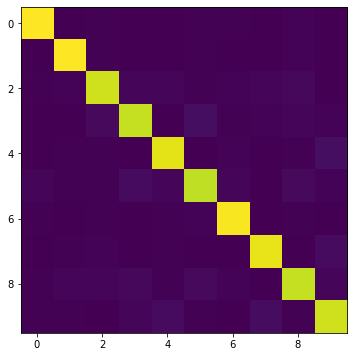

[[0.971 0.    0.004 0.002 0.002 0.006 0.007 0.001 0.008 0.001]
 [0.    0.972 0.005 0.003 0.001 0.005 0.001 0.003 0.009 0.001]
 [0.006 0.01  0.904 0.014 0.013 0.005 0.01  0.014 0.022 0.003]
 [0.004 0.004 0.025 0.889 0.001 0.036 0.004 0.01  0.019 0.009]
 [0.002 0.005 0.006 0.001 0.931 0.001 0.01  0.003 0.006 0.035]
 [0.012 0.005 0.007 0.029 0.012 0.879 0.017 0.003 0.026 0.009]
 [0.006 0.002 0.007 0.    0.006 0.011 0.961 0.001 0.005 0.   ]
 [0.003 0.005 0.011 0.003 0.007 0.001 0.    0.938 0.002 0.028]
 [0.006 0.019 0.013 0.021 0.004 0.026 0.008 0.003 0.886 0.013]
 [0.004 0.005 0.004 0.013 0.027 0.006 0.    0.031 0.007 0.903]]


In [131]:
# display confusion matrix
M,acc = Confusion(trainData, trainLabels, linearClassifier)
VisualizeConfusion(M)

### Part 2: Single Layer Perceptron [2 pts]
The simple linear classifier implemented in the cell already performs quite well. Plot the filter weights corresponding to each output class (weights, not biases) as images. (Normalize weights to lie between 0 and 1 and use color maps like 'inferno' or 'plasma' for good results). Comment on what the weights look like and why that may be so.


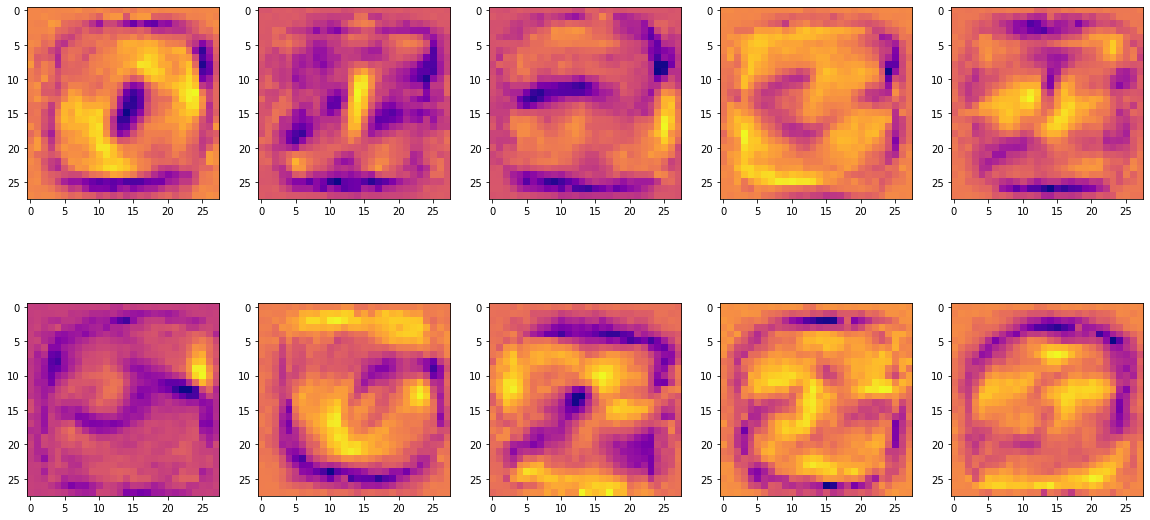

In [20]:
# Plot filter weights corresponding to each class, you may have to reshape them to make sense out of them
# linearClassifier.weight1.data will give you the first layer weights
weights = linearClassifier.weight1.detach().numpy()
weighs = normalize(weights)
plt.figure(figsize = (20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(w2[i].reshape((28,28)),cmap = 'plasma')

#### Comments on weights

The weights resemble distorted versions digits that they are intended to classify. They are akin to a template for each digit and therefore they should image that has the highest match to the template is going to have the highest probability coming out of the softmax classifier. The templates are very distorted versions of the digits because they have to try and capture all of the possible permutations of the digit they are supposed to classify while having enough difference between the other templates to separate itself.



### Part 3: Multi Layer Perceptron (MLP) [5 pts]
Here you will implement an MLP. The MLP should consist of 2 layers (matrix multiplication and bias offset) that map to the following feature dimensions:

* 28x28 -> hidden (100)
* hidden -> classes

* The hidden layer should be followed with a ReLU nonlinearity. The final layer should not have a nonlinearity applied as we desire the raw logits output.
* The final output of the computation graph should be stored in self.y as that will be used in the training.

Display the confusion matrix and accuracy after training. Note: You should get ~ 97 % accuracy for 10 epochs and batch size 50.

Plot the filter weights corresponding to the mapping from the inputs to the first 10 hidden layer outputs (out of 100). Do the weights look similar to the weights plotted in the previous problem? Why or why not?

In [21]:
class MLPClassifier(DNN):
    def __init__(self,td, in_features=28*28, classes=10, hidden=100):
        
        super().__init__(td)
        self.classes = classes
        self.in_features = in_features
        self.td = td
        self.hidden = hidden
        self.weights1 = weight_variable((self.in_features,self.hidden)) # 14x14x5 # weights for the first kernel
        self.bias1    = bias_variable((self.hidden))
        self.weights2 = weight_variable((self.hidden,self.classes)) #7x7x10 # weights for the second kernel 
        self.bias2    = bias_variable((self.classes))

        #raise NotImplementedError
    
    def forward(self, x):
        
        h1 = torch.addmm(self.bias1, x.view(list(x.size())[0], -1), self.weights1)
        h1_relu = h1.clamp(min=0)
        linear = torch.addmm(self.bias2,h1_relu,self.weights2)
        self.y = linear
        
        return self.y
        raise NotImplementedError

mlpClassifer = MLPClassifier(trainData)


In [22]:
mlpClassifer.train_net(trainData, trainLabels, epochs=10, batchSize=50)

Epoch:1 Accuracy: 91.250000
Epoch:2 Accuracy: 92.960000
Epoch:3 Accuracy: 94.000000
Epoch:4 Accuracy: 95.060000
Epoch:5 Accuracy: 95.590000
Epoch:6 Accuracy: 95.940000
Epoch:7 Accuracy: 96.420000
Epoch:8 Accuracy: 96.620000
Epoch:9 Accuracy: 96.770000
Epoch:10 Accuracy: 96.900000


In [138]:
mlpClassifer.weights1.size()

torch.Size([784, 100])

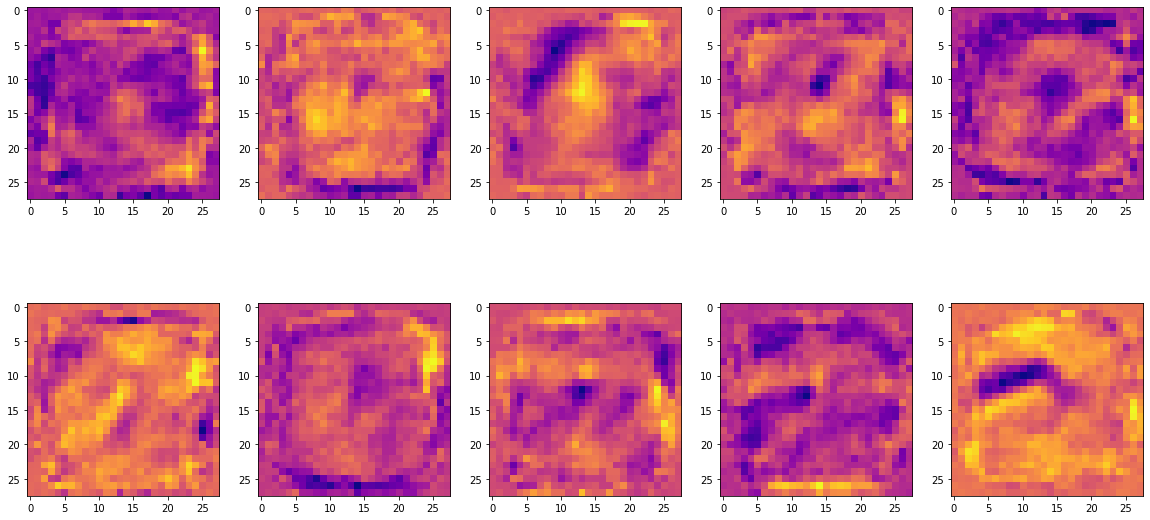

In [23]:
weights = mlpClassifer.weights1.detach().numpy()
weights10 = weights[:,:10]
plt.figure(figsize = (20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(weights10[:,i].reshape((28,28)),cmap = 'plasma')

#### Comments on weights:

They do not resemble the linear classifier. The hidden layer embeddes the data in a different more compressed representation (784 -> 100) and what we are seeing is the template that network uses to embed the image into each node of the hidden layer. 

### Part 3: Convolutional Neural Network (CNN) [5 pts]
Here you will implement a CNN with the following architecture:

* n=5
* ReLU( Conv(kernel_size=5x5, stride=2, output_features=n) )
* ReLU( Conv(kernel_size=5x5, stride=2, output_features=n*2) )
* ReLU( Linear(hidden units = 64) )
* Linear(output_features=classes)

So, 2 convolutional layers, followed by 1 fully connected hidden layer and then the output layer

Display the confusion matrix and accuracy after training. You should get around ~ 98 % accuracy for 10 epochs and batch size 50.<br><br>
**Note: You are not allowed to use torch.nn.Conv2d() and torch.nn.Linear(), Using these will lead to deduction of points. Use the declared conv2d(), weight_variable() and bias_variable() functions.** Although, in practice, when you move forward after this class you will use torch.nn.Conv2d() which makes life easier and hides all the operations underneath.

In [69]:
def conv2d(x, W, stride):
    # x: input
    # W: weights (out, in, kH, kW)
    return F.conv2d(x, W, stride=stride, padding=2)


# https://pytorch.org/docs/stable/_modules/torch/nn/modules/conv.html
# Defining a Convolutional Neural Network
class CNNClassifer(DNN):
    def __init__(self, classes=10, n=5,td=trainData):
        super().__init__(td)
        self.classes = classes
        self.n = n
        self.td = td
        self.stride = 2
        self.weights1 = weight_variable((self.n,1,5,5)) # 14x14x5 # weights for the first kernel
        self.bias1    = bias_variable((1,5,14,14))
        self.weights2 = weight_variable((self.n*2,self.n,5,5)) #7x7x10 # weights for the second kernel 
        self.bias2    = bias_variable((1,10,7,7))
        self.weights3 = weight_variable((490,64)) # 490 -> 64
        self.bias3    = bias_variable((1,64))
        self.weights4 = weight_variable((64,10))
        self.bias4    = bias_variable((1,10))
        
    def forward(self, x):
        
        conv1 = conv2d(x,self.weights1,stride=self.stride)
        #print(conv1.size())
        #print(self.bias1.size())
        
        #print(self.bias2.size())
        conv1_b1 = torch.add(conv1,self.bias1)
        conv1_b1_relu = conv1_b1.clamp(min=0)
        
        conv2 = conv2d(conv1_b1_relu,self.weights2,stride=self.stride)
        #print(conv2.size())
        conv2_b2 = torch.add(conv2,self.bias2)
        c1_b1_r1_c2_b2_r2 = conv2.clamp(min=0)
        
        
        c1b1rc2b2r_flat = c1_b1_r1_c2_b2_r2.view(list(c1_b1_r1_c2_b2_r2.size())[0], -1)
        #print(c1b1rc2b2r_flat.size(),self.weights3.size(),self.bias3.size())
        h1 = torch.addmm(self.bias3, c1b1rc2b2r_flat, self.weights3)
        #h1 = c1b1rc2b2r_flat.mm(self.weights3)
        
        h1_relu = h1.clamp(min=0)
        linear = torch.addmm(self.bias4,h1_relu,self.weights4)
        #linear = h1_relu.mm(self.weights4)       
        self.y = linear
        return self.y
        """ ==========
        YOUR CODE HERE
        ========== """

cnnClassifer = CNNClassifer(td = trainData)
cnnClassifer.train_net(trainData, trainLabels, epochs=10)

Epoch:1 Accuracy: 90.860000
Epoch:2 Accuracy: 94.160000
Epoch:3 Accuracy: 95.050000
Epoch:4 Accuracy: 96.030000
Epoch:5 Accuracy: 96.420000
Epoch:6 Accuracy: 96.970000
Epoch:7 Accuracy: 97.210000
Epoch:8 Accuracy: 97.050000
Epoch:9 Accuracy: 97.640000
Epoch:10 Accuracy: 97.620000


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10027.02it/s]


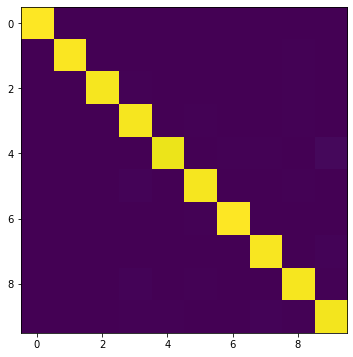

[[0.99  0.    0.001 0.001 0.    0.001 0.002 0.001 0.003 0.001]
 [0.    0.985 0.002 0.002 0.001 0.    0.    0.001 0.007 0.002]
 [0.001 0.002 0.976 0.006 0.001 0.001 0.001 0.004 0.007 0.002]
 [0.    0.    0.003 0.978 0.    0.006 0.    0.003 0.005 0.004]
 [0.    0.001 0.003 0.    0.96  0.001 0.006 0.004 0.002 0.022]
 [0.    0.001 0.    0.01  0.    0.978 0.003 0.001 0.004 0.002]
 [0.002 0.001 0.    0.    0.001 0.004 0.99  0.    0.003 0.   ]
 [0.    0.002 0.003 0.001 0.001 0.    0.    0.979 0.003 0.01 ]
 [0.001 0.003 0.001 0.008 0.001 0.005 0.001 0.    0.976 0.004]
 [0.001 0.    0.    0.006 0.005 0.003 0.001 0.008 0.004 0.972]]


In [26]:
# Plot Confusion matrix
M,acc = Confusion(trainData, trainLabels, cnnClassifer)
VisualizeConfusion(M)

In [24]:
# weights = cnnClassifer.weights1.detach().numpy()
# weights2 = cnnClassifer.weights2.detach().numpy()
# for i in range(5):
#     plt.subplot(1,5,i+1)
#     plt.imshow(weights[i,0,:,:])

# plt.show()
# weights2.shape


* Note that the MLP/ConvNet approaches lead to an accuracy a little higher than the K-NN approach. 
* In general, Neural net approaches lead to significant increase in accuracy, but in this case since the problem is not too hard, the increase in accuracy is not very high.
* However, this is still quite significant considering the fact that the ConvNets we've used are relatively simple while the accuracy achieved using K-NN is with a search over 60,000 training images for every test image.
* You can look at the performance of various machine learning methods on this problem at http://yann.lecun.com/exdb/mnist/
* You can learn more about neural nets/ pytorch at<br> https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
* You can play with a demo of neural network created by Daniel Smilkov and Shan Carter at https://playground.tensorflow.org/